In [65]:
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super(Mlp, self).__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super(WindowAttention, self).__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """

        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH

        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=2, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        self.red = nn.Linear(2 * dim, dim)
        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x, hx=None):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        if hx is not None:
            hx = self.norm1(hx)
            x = torch.cat((x, hx), -1)
            x = self.red(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)

        # reverse cyclic shift
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x

        # FFN
        x = x.view(B, H * W, C)
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.
        patch_size (int): Patch token size.
        in_chans (int): Number of input image channels.
        embed_dim (int): Number of linear projection output channels.
    """

    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        super(PatchEmbed, self).__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
       # print('x shape patchembed forward',x.shape)
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x


class PatchInflated(nn.Module):
    r""" Tensor to Patch Inflating

    Args:
        in_chans (int): Number of input image channels.
        embed_dim (int): Number of linear projection output channels.
        input_resolution (tuple[int]): Input resulotion.
    """

    def __init__(self, in_chans, embed_dim, input_resolution, stride=2, padding=1, output_padding=1):
        super(PatchInflated, self).__init__()

        stride = to_2tuple(stride)
        padding = to_2tuple(padding)
        output_padding = to_2tuple(output_padding)
        self.input_resolution = input_resolution

        self.ConvT = nn.ConvTranspose2d(in_channels=embed_dim, out_channels=in_chans, kernel_size=(3, 3),
                                        stride=stride, padding=padding, output_padding=output_padding)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)
        x = x.permute(0, 3, 1, 2)
        x = self.ConvT(x)

        return x


class SwinTransformerBlocks(nn.Module):

    def __init__(self, dim, input_resolution, depth, num_heads, window_size, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop=0., attn_drop=0., drop_path=0., norm_layer=nn.LayerNorm):
        super(SwinTransformerBlocks, self).__init__()
        self.layers = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

    def forward(self, xt, hx):

        outputs = []

        for index, layer in enumerate(self.layers):
            if index == 0:
                x = layer(xt, hx)
                outputs.append(x)

            else:
                if index % 2 == 0:
                    x = layer(outputs[-1], xt)
                    outputs.append(x)

                if index % 2 == 1:
                    x = layer(outputs[-1], None)
                    outputs.append(x)

        return outputs[-1]


class SwinLSTMCell(nn.Module):

    def __init__(self, dim, input_resolution, num_heads, window_size, depth,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm):
        super(SwinLSTMCell, self).__init__()

        self.Swin = SwinTransformerBlocks(dim=dim, input_resolution=input_resolution, depth=depth,
                                          num_heads=num_heads, window_size=window_size, mlp_ratio=mlp_ratio,
                                          qkv_bias=qkv_bias, qk_scale=qk_scale, drop=drop, attn_drop=attn_drop,
                                          drop_path=drop_path, norm_layer=norm_layer)

    def forward(self, xt, hidden_states):
        if hidden_states is None:
            B, L, C = xt.shape
            hx = torch.zeros(B, L, C).to(xt.device)
            cx = torch.zeros(B, L, C).to(xt.device)

        else:
            hx, cx = hidden_states

        Ft = self.Swin(xt, hx)

        gate = torch.sigmoid(Ft)
        cell = torch.tanh(Ft)

        cy = gate * (cx + cell)
        hy = gate * torch.tanh(cy)
        hx = hy
        cx = cy

        return hx, (hx, cx)


class STconvert(nn.Module):
    r""" STconvert

    Args:
        img_size (int | tuple(int)): Input image size.
        patch_size (int | tuple(int)): Patch size.
        in_chans (int): Number of input image channels.
        embed_dim (int): Patch embedding dimension.
        depths (tuple(int)): Depth of Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
    """

    def __init__(self, img_size, patch_size, in_chans, embed_dim, depths, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm):

        super(STconvert, self).__init__()

        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.mlp_ratio = mlp_ratio
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size,
                                      in_chans=in_chans, embed_dim=embed_dim)
        patches_resolution = self.patch_embed.patches_resolution

        self.PatchInflated = PatchInflated(in_chans=in_chans, embed_dim=embed_dim, input_resolution=patches_resolution)
        self.layers = nn.ModuleList()

        for i_layer in range(self.num_layers):
            layer = SwinLSTMCell(dim=embed_dim,
                                 input_resolution=(patches_resolution[0], patches_resolution[1]),
                                 depth=depths[i_layer],
                                 num_heads=num_heads[i_layer],
                                 window_size=window_size,
                                 mlp_ratio=self.mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop_rate, attn_drop=attn_drop_rate,
                                 drop_path=drop_path_rate,
                                 norm_layer=norm_layer)

            self.layers.append(layer)

    def forward(self, x, h):
       # print('stconvert x shape',x.shape)
        x = self.patch_embed(x)

        hidden_states = []

        for index, layer in enumerate(self.layers):
            x, hidden_state = layer(x, h[index])
            hidden_states.append(hidden_state)
       # print('x shape before convert',x.shape)
        x = torch.sigmoid(self.PatchInflated(x))
       # print('x shape st convert',x.shape)
        return hidden_states, x


class SwinLSTM(nn.Module):
    r""" SwinLSTM

    Args:
        img_size (int | tuple(int)): Input image size.
        patch_size (int | tuple(int)): Patch size.
        in_chans (int): Number of input image channels.
        embed_dim (int): Patch embedding dimension.
        depths (tuple(int)): Depth of Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size.
        drop_rate (float): Dropout rate.
        attn_drop_rate (float): Attention dropout rate.
        drop_path_rate (float): Stochastic depth rate.
    """

   
    def __init__(self, img_size=40, patch_size=4, in_chans=4,out_chans=1, embed_dim=128, depths=[2, 2],
                 num_heads=[4, 8], window_size=2, drop_rate=0, attn_drop_rate=0.1, drop_path_rate=0.1):
        super(SwinLSTM, self).__init__()

        self.ST = STconvert(img_size=img_size, patch_size=patch_size, in_chans=in_chans,
                            embed_dim=embed_dim, depths=depths,
                            num_heads=num_heads, window_size=window_size, drop_rate=drop_rate,
                            attn_drop_rate=attn_drop_rate, drop_path_rate=drop_path_rate)
         # Add a final convolution layer to reduce channels from embed_dim to out_chans
        self.final_conv = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=1, stride=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=True)

    def forward(self, input, states):
        # input shape: (batch_size, 40, 40, 4)
        states_next, output = self.ST(input, states)
       # print('x shape st convert', output.shape)  # Should be [32, 4, 20, 20]
        
        output = self.final_conv(output)  # Should maintain [32, 4, 20, 20]
        output = self.upsample(output)  # Will upsample to [32, 4, 40, 40]
        
        # If you need to reduce to a single channel:
        output = output.mean(dim=1, keepdim=True)  # Will be [32, 1, 40, 40]
        
        return output.squeeze(1), states_next  # Will be [32, 40, 40]

In [4]:
import numpy as np
import torch

# Load radar data
movies = np.load('/home/sushen/PhysNet-RadarNowcast/tests/rect_movie.npy')import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch

def animate_comparison(model, data_loader, output_folder):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Extract a single batch for visualization
    inputs, targets = next(iter(data_loader))
    
    # Move inputs to the same device as the model
    inputs = inputs.to(next(model.parameters()).device)
    
    # Get model predictions
    with torch.no_grad():
        # Initialize hidden states
        states = [None] * 1
        outputs,states = model(inputs,states)
    
    # Assuming outputs and targets are on GPU, move them to CPU and convert to numpy
    outputs = outputs.cpu().numpy()
    targets = targets.cpu().numpy()
    
    # Prepare figure for animation
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    def update(i):
        # Clear previous content
        ax[0].cla()
        ax[1].cla()
        
        # Update content for frame i
        ax[0].imshow(outputs[i].squeeze(), cmap='gray')
        ax[0].set_title('Output')
        ax[1].imshow(targets[i].squeeze(), cmap='gray')
        ax[1].set_title('Target')
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=len(outputs), interval=200)
    
    # Save animation
    anim.save(f'{output_folder}/comparison_animation.gif', writer='imagemagick')

# Example usage
animate_comparison(model, test_loader, '/home/sushen/PhysNet-RadarNowcast/images/vit')

# Prepare inputs (x) and targets (y)
x = movies[:, :, :, :4]  # (980, 40, 40, 4)
y = movies[:, :, :, 4:5]  # (980, 40, 40, 1)

# Split data into train, validate, test sets
tvt = np.tile(['train', 'train', 'train', 'validate', 'test'], y.shape[0])[:y.shape[0]]
x_train = x[np.where(tvt == 'train')]
y_train = y[np.where(tvt == 'train')]
x_validate = x[np.where(tvt == 'validate')]
y_validate = y[np.where(tvt == 'validate')]
x_test = x[np.where(tvt == 'test')]
y_test = y[np.where(tvt == 'test')]

In [6]:
import torch
from torch.utils.data import Dataset
import numpy as np

class RadarDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).float()
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx].permute(2, 0, 1), self.y[idx].squeeze(2)  # (4, 40, 40), (40, 40)

# Create datasets
train_dataset = RadarDataset(x_train, y_train)
val_dataset = RadarDataset(x_validate, y_validate)
test_dataset = RadarDataset(x_test, y_test)

# Create data loaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
       # print('inputs shape',inputs.shape)  
        states = [None] * len(model.ST.layers)
        outputs, _ = model(inputs, states)
        #print(outputs.shape, targets.shape)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def test(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            
            states = [None] * len(model.ST.layers)
            outputs, _ = model(inputs, states)
            
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    
    return total_loss / len(test_loader)

# Set up training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the model
model = SwinLSTM().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss = test(model, val_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Evaluate on test set
test_loss = test(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")

100%|██████████| 7/7 [00:00<00:00, 171.37it/s]


Epoch 1/50, Train Loss: 0.0273, Val Loss: 0.0038


100%|██████████| 7/7 [00:00<00:00, 146.38it/s]


Epoch 2/50, Train Loss: 0.0048, Val Loss: 0.0034


100%|██████████| 7/7 [00:00<00:00, 187.03it/s]


Epoch 3/50, Train Loss: 0.0031, Val Loss: 0.0031


100%|██████████| 7/7 [00:00<00:00, 172.67it/s]


Epoch 4/50, Train Loss: 0.0028, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 179.08it/s]


Epoch 5/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 170.55it/s]


Epoch 6/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 190.43it/s]


Epoch 7/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 163.31it/s]


Epoch 8/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 190.00it/s]


Epoch 9/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 175.17it/s]


Epoch 10/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 184.59it/s]


Epoch 11/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 196.65it/s]


Epoch 12/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 195.58it/s]


Epoch 13/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 157.62it/s]


Epoch 14/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 177.77it/s]


Epoch 15/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 178.83it/s]


Epoch 16/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 178.75it/s]


Epoch 17/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 145.07it/s]


Epoch 18/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 166.08it/s]


Epoch 19/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 182.71it/s]


Epoch 20/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 183.16it/s]


Epoch 21/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 110.80it/s]


Epoch 22/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 196.23it/s]


Epoch 23/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 179.86it/s]


Epoch 24/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 145.78it/s]


Epoch 25/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 161.16it/s]


Epoch 26/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 134.52it/s]


Epoch 27/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 167.55it/s]


Epoch 28/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 180.82it/s]


Epoch 29/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 178.54it/s]


Epoch 30/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 171.01it/s]


Epoch 31/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 170.45it/s]


Epoch 32/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 137.22it/s]


Epoch 33/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 177.54it/s]


Epoch 34/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 178.04it/s]


Epoch 35/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 130.64it/s]


Epoch 36/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 178.12it/s]


Epoch 37/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 181.79it/s]


Epoch 38/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 174.05it/s]


Epoch 39/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 170.65it/s]


Epoch 40/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 168.23it/s]


Epoch 41/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 189.84it/s]


Epoch 42/50, Train Loss: 0.0028, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 192.42it/s]


Epoch 43/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 190.18it/s]


Epoch 44/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 190.43it/s]


Epoch 45/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 178.63it/s]


Epoch 46/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 170.63it/s]


Epoch 47/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 190.93it/s]


Epoch 48/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 177.92it/s]


Epoch 49/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 176.45it/s]


Epoch 50/50, Train Loss: 0.0027, Val Loss: 0.0030


100%|██████████| 7/7 [00:00<00:00, 192.63it/s]

Test Loss: 0.0027


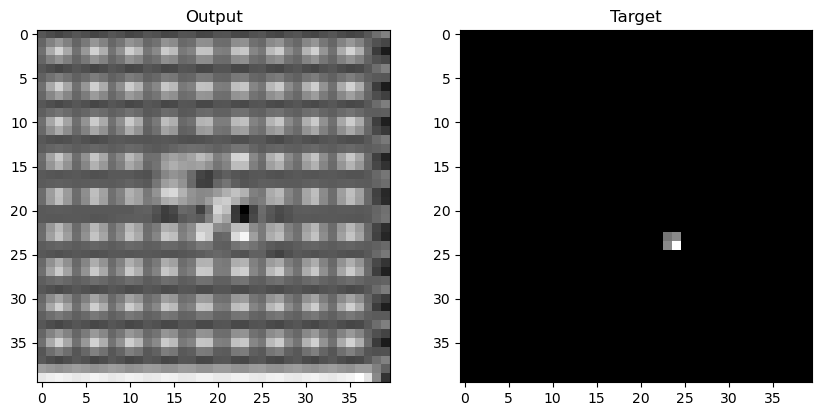

In [67]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

def animate_comparison(model, data_loader, output_folder, device):
    model.eval()
    
    inputs, targets = next(iter(data_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    
    with torch.no_grad():
        states = [None] * len(model.ST.layers)
        outputs, _ = model(inputs, states)
    
    outputs = outputs.cpu().numpy()
    targets = targets.cpu().numpy()
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    def update(i):
        ax[0].cla()
        ax[1].cla()
        
        ax[0].imshow(outputs[i].squeeze(), cmap='gray')
        ax[0].set_title('Output')
        ax[1].imshow(targets[i].squeeze(), cmap='gray')
        ax[1].set_title('Target')
    
    anim = FuncAnimation(fig, update, frames=len(outputs), interval=200)
    anim.save(f'{output_folder}/swinLSTM2_comparison_animation.gif', writer='imagemagick')

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinLSTM().to(device)  # Assuming SwinLSTM is defined elsewhere
animate_comparison(model, test_loader, '/home/sushen/PhysNet-RadarNowcast/images/vit', device)